# Variational autoencoder and its extensions


---

This notebook demonstrates application of different variational autoencoders (VAEs) to rotated images. Specifically, we discuss rotationally invariant version of VAE (rVAE) and class-conditioned VAE and rVAE.

Prepared by Maxim Ziatdinov  (Feb 2021)

E-mail: maxim.ziatdinov@ai4microscopy.com

---



## Installation/Imports/Utility functions

*Make sure to click "Play" button for the next 4 cells ("Installation and Imports", "Load neural networks for VAE", etc.) to load all the necessary modules and functions!*

In [1]:
#@title Installation and Imports

!pip install -qq pyro-ppl

from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

In [2]:
from rvae import *
from models import *
from functions import *
from trainer import *
from data import *
from classifier import *

Get rotated MNIST data and pass it to dataloader that will be used for (r)VAE training:

## Get training data

In [3]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
train_data, train_labels, train_angles = get_rotated_mnist(mnist_trainset, rotation_range=[-60, 61])
test_data, test_labels, test_angles = get_rotated_mnist(mnist_testset, rotation_range=[-60, 61])
train_loader = init_dataloader(train_data, batch_size=200)
test_loader = init_dataloader(test_data, batch_size=200)
# train_loader = init_dataloader(train_data, batch_size=200)

Plot samples from the rotated MNIST dataset:

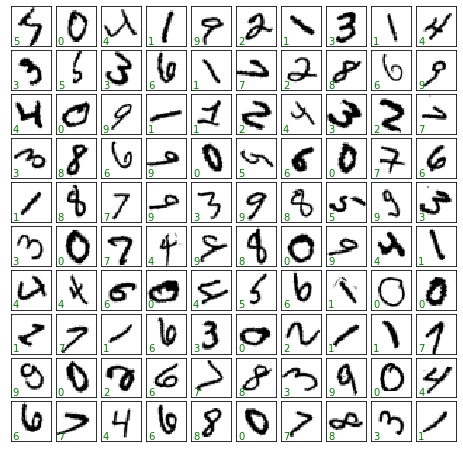

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

## Define model and trainer

Next, we define our rVAE as a probabilistic model. To do this, first, we define our generative model (aka decoder) whose goal is to reconstruct observations (images) from the latent "code". Then we write an appropriate *guide* function (aka encoder) whose job is to ‘guess’ good values for the latent random variables. We are also going to add some helper functions to the rVAE class for the encoding of images and visualization of the learned latent manifold so that we do not have to write them over and over again.

We also define a stochastic variational inference (SVI) trainer for model training and evaluation:

## Train different VAE models

### Vanilla VAE

In [4]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
vae = rVAE(in_dim, latent_dim=2, coord=0, seed=0)

# # Initialize SVI trainer
trainer = SVItrainer(vae)
# # Train for n epochs:
# for e in range(100):
#     trainer.step(train_loader)
#     trainer.print_statistics()
# trainer.save_model(vae, 'saved_models/vae_rotation.pkl')
trainer.load_model(vae, 'saved_models/vae_rotation.pkl')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


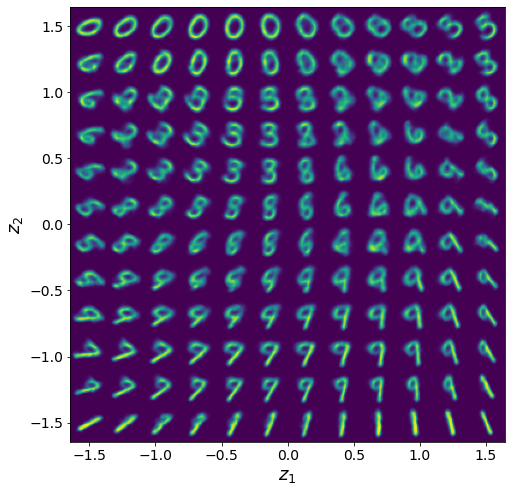

In [36]:
vae.manifold2d(d=12, cmap='viridis')

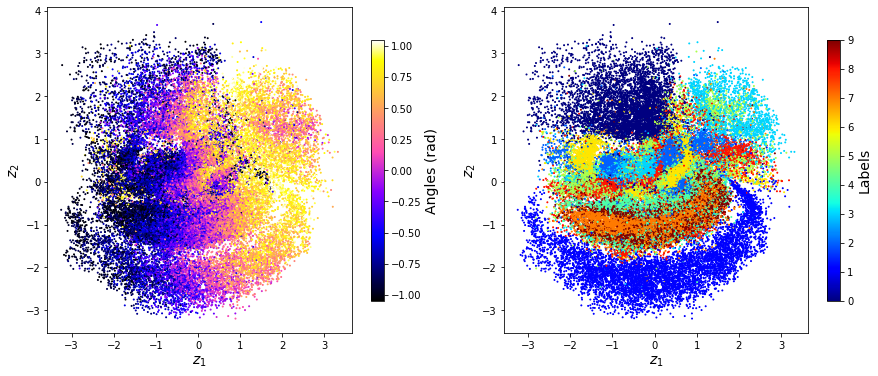

In [38]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In [47]:
# mnist_train = datasets.MNIST('data/mnist/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
# mnist_test = datasets.MNIST('data/mnist/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_trainset = [[train_data[i], train_labels[i]] for i in range(len(train_data))]
mnist_testset = [[test_data[i], test_labels[i]] for i in range(len(test_data))]

In [6]:
import pickle
model = MLP()
model.to(device)
# mlp_mnist_results = train_nn(model, vae, mnist_trainset, mnist_testset, num_epochs = 100)
# with open('saved_models/dict_vae_rotated_mnist_classifier.pkl', 'wb') as handle:
#     pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model.state_dict(), 'saved_models/vae_rotated_mnist_classifier.pkl')    

with open('saved_models/dict_vae_rotated_mnist_classifier.pkl', 'rb') as handle:
    results = pickle.load(handle)
model.load_state_dict(torch.load('saved_models/vae_rotated_mnist_classifier.pkl'))

<All keys matched successfully>

### Train rotationally-invariant VAE (rVAE)

#### Rotated images

In [3]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)

# train_data, train_labels, train_angles = get_rotated_mnist(mnist_trainset, rotation_range=[-60, 61])
# test_data, test_labels, test_angles = get_rotated_mnist(mnist_testset, rotation_range=[-60, 61])
train_data, train_labels, train_angles = get_rotated_mnist_sample(mnist_trainset, n_samples = 3000, rotation_range=[-60, 61])
test_data, test_labels, test_angles = get_rotated_mnist_sample(mnist_testset, n_samples = 3000, rotation_range=[-60, 61])
#batch size 32 with n_samples = 200

train_loader = init_dataloader(train_data, batch_size=200)
test_loader = init_dataloader(test_data, batch_size=200)
# train_loader = init_dataloader(train_data, batch_size=200)

Re-initialize dataloader:

Train rVAE:

In [4]:
%%capture cap_f1
in_dim = (28, 28)
# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
rvae = rVAE(in_dim, latent_dim=2, coord=1, seed=0)

# Initialize SVI trainer
trainer = SVItrainer(rvae)

# # Train for n epochs:ccc
# for e in range(100):
#     # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
#     # It is optional, and the rvae will also work without it
#     trainer.step(train_loader, scale_factor=3)
#     trainer.print_statistics()
# trainer.save_model(rvae, 'saved_models/rvae_rotation.pkl')
# trainer.load_model(rvae, 'saved_models/rvae_rotation.pkl')
# trainer.save_model(rvae, 'saved_models/rvae_rotation_sampels_200.pkl')
# trainer.load_model(rvae, 'saved_models/rvae_rotation_sampels_200.pkl')
# trainer.save_model(rvae, 'saved_models/rvae_rotation_sampels_3000.pkl')
trainer.load_model(rvae, 'saved_models/rvae_rotation_sampels_3000.pkl')

# trainer.save_model(rvae, 'saved_models/vae_rotation_sampels_200.pkl')
# trainer.load_model(rvae, 'saved_models/vae_rotation_sampels_200.pkl')
# trainer.save_model(rvae, 'saved_models/vae_rotation_sampels_1000.pkl')
# trainer.load_model(rvae, 'saved_models/vae_rotation_sampels_1000.pkl')
# trainer.save_model(rvae, 'saved_models/vae_rotation_sampels_3000.pkl')
# trainer.load_model(rvae, 'saved_models/vae_rotation_sampels_3000.pkl')

##### Vaisualtions

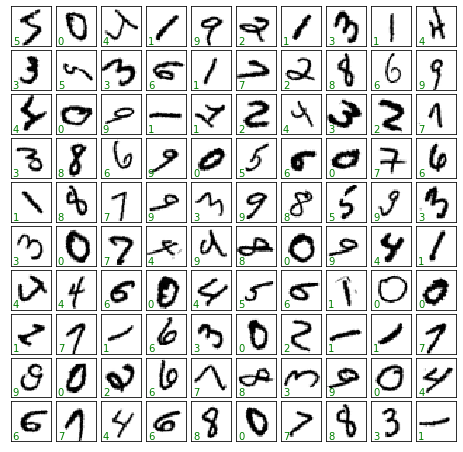

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

In [6]:
# with open('saved_models/rvae_rotation_log.txt', 'w') as f: f.write(cap_f1.stdout)

View the learned manifold:

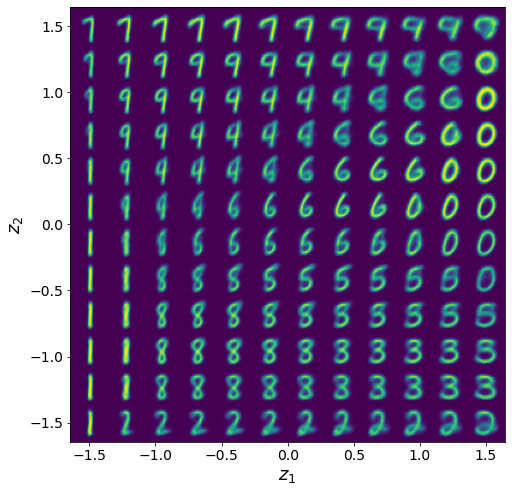

In [93]:
rvae.manifold2d(d=12, cmap="viridis")

Encode all the data and view the encoded values as a scatter plot:

(note that we adjusted the orientations of the scatter plots and the manifold image such that digits look normal (and not upside down) to a human eye)

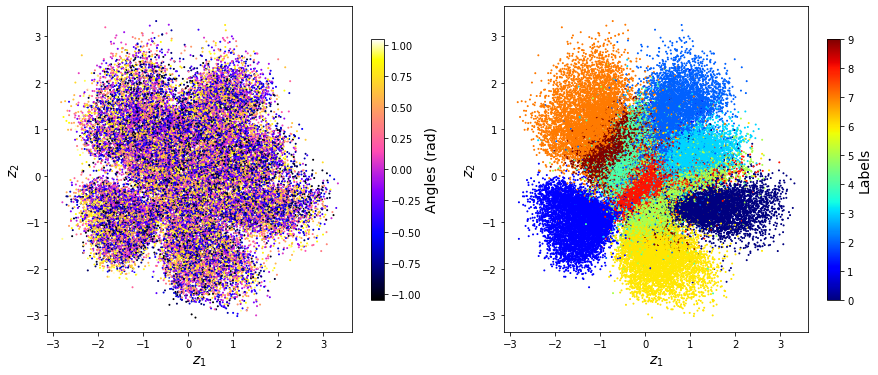

In [102]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

Plot true angles vs. encoded angles:

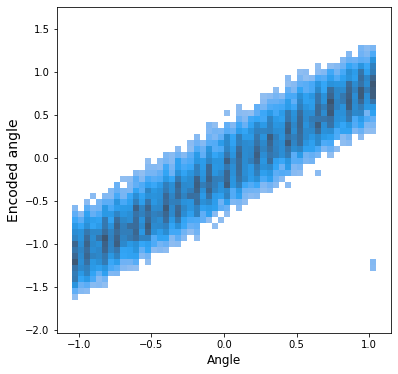

In [96]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=train_angles, y=z_mean[:, 0], bins=50, pthresh=.1);

In [9]:
z = rvae.encode(test_data)
x_decoded = rvae.decode(z)

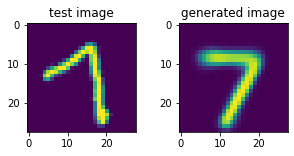

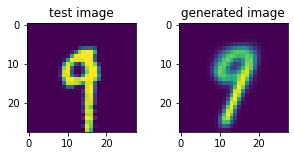

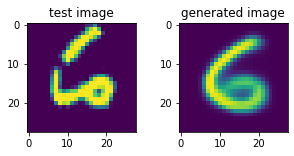

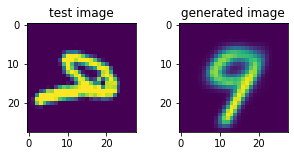

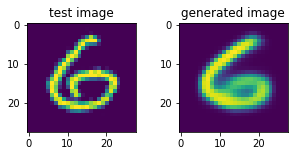

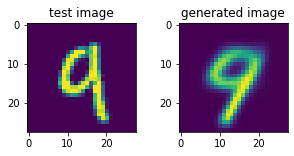

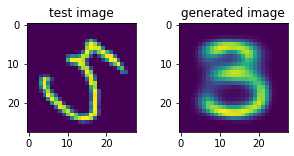

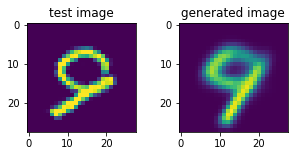

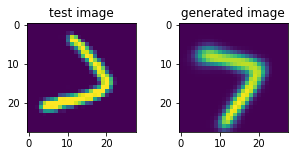

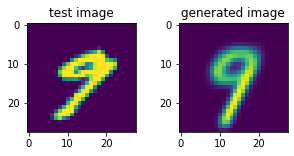

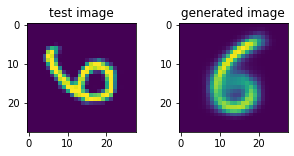

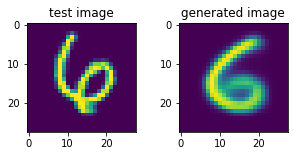

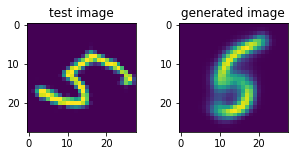

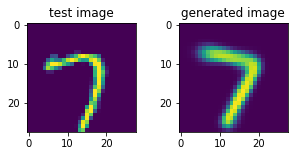

In [81]:
for i in range(30):
    if test_labels[i]>=5:
        # plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(5, 2))
        ax1.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
        ax1.set_title('test image')
        ax2.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())
        ax2.set_title('generated image')
        # plt.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
        # plt.figure()
        # plt.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())

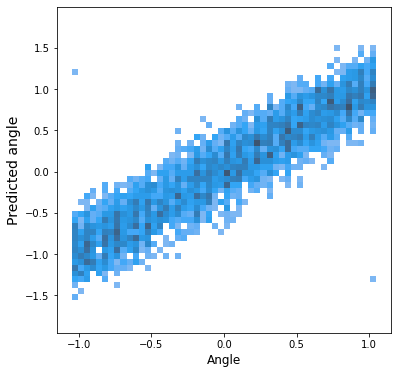

In [103]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Predicted angle", fontsize=14)
ax = sns.histplot(x=test_angles, y=z[0][:, 0], bins=50, pthresh=.1);

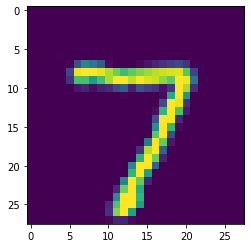

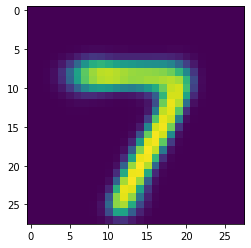

In [10]:
plt.figure()
plt.imshow(test_data[0].view(28, 28).cpu().detach().numpy())
plt.figure()
plt.imshow(x_decoded[0].view(28, 28).cpu().detach().numpy())

#### Recognition classifier

In [6]:
# mnist_train = datasets.MNIST('data/mnist/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
# mnist_test = datasets.MNIST('data/mnist/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_trainset = [[train_data[i], train_labels[i]] for i in range(len(train_data))]
mnist_testset = [[test_data[i], test_labels[i]] for i in range(len(test_data))]

In [7]:
import pickle
model = MLP()
model.to(device)
# mlp_mnist_results = train_nn(model, rvae, mnist_trainset, mnist_testset, num_epochs = 100)
# with open('saved_models/dict_rvae_rotated_mnist_classifier.pkl', 'wb') as handle:
#     pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model.state_dict(), 'saved_models/rvae_rotated_mnist_classifier.pkl')    
# with open('saved_models/dict_rvae_rotated_mnist_classifier.pkl', 'rb') as handle:
#     results = pickle.load(handle)
# model.load_state_dict(torch.load('saved_models/rvae_rotated_mnist_classifier.pkl'))

# mlp_mnist_results = train_nn(model, rvae, mnist_trainset, mnist_testset, num_epochs = 100)
# with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_200.pkl', 'wb') as handle:
#     pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model.state_dict(), 'saved_models/rvae_rotated_mnist_classifier_sampels_200.pkl')    
# with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_200.pkl', 'rb') as handle:
#     results = pickle.load(handle)
# model.load_state_dict(torch.load('saved_models/rvae_rotated_mnist_classifier_sampels_200.pkl'))

# mlp_mnist_results = train_nn(model, rvae, mnist_trainset, mnist_testset, num_epochs = 40)
# with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_200.pkl', 'wb') as handle:
#     pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model.state_dict(), 'saved_models/vae_rotated_mnist_classifier_sampels_200.pkl')    
# with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_200.pkl', 'rb') as handle:
#     results = pickle.load(handle)
# model.load_state_dict(torch.load('saved_models/vae_rotated_mnist_classifier_sampels_200.pkl'))

# mlp_mnist_results = train_nn(model, rvae, mnist_trainset, mnist_testset, num_epochs = 40)
# with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_1000.pkl', 'wb') as handle:
#     pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model.state_dict(), 'saved_models/vae_rotated_mnist_classifier_sampels_1000.pkl')    
# with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_1000.pkl', 'rb') as handle:
#     results = pickle.load(handle)
# model.load_state_dict(torch.load('saved_models/vae_rotated_mnist_classifier_sampels_1000.pkl'))

# mlp_mnist_results = train_nn(model, rvae, mnist_trainset, mnist_testset, num_epochs = 40)
# with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_3000.pkl', 'wb') as handle:
#     pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model.state_dict(), 'saved_models/vae_rotated_mnist_classifier_sampels_3000.pkl')    
# with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_3000.pkl', 'rb') as handle:
#     results = pickle.load(handle)
# model.load_state_dict(torch.load('saved_models/vae_rotated_mnist_classifier_sampels_3000.pkl'))

mlp_mnist_results = train_nn(model, rvae, mnist_trainset, mnist_testset, num_epochs = 40)
with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_3000.pkl', 'wb') as handle:
    pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
torch.save(model.state_dict(), 'saved_models/rvae_rotated_mnist_classifier_sampels_3000.pkl')    
with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_3000.pkl', 'rb') as handle:
    results = pickle.load(handle)
model.load_state_dict(torch.load('saved_models/rvae_rotated_mnist_classifier_sampels_3000.pkl'))

  0%|                                                   | 0/938 [00:00<?, ?it/s]/u/gaurii/gaurii/Invariant-AE/classifier.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=F.softmax(self.fc2(x))
100%|████████████████████████████████████████| 938/938 [00:04<00:00, 197.76it/s]


Epoch 0: Train Loss=1.9201924615323163 Validation Accuracy=70.7867412140575%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 255.22it/s]


Epoch 1: Train Loss=1.7891847805173666 Validation Accuracy=72.02476038338658%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 255.57it/s]


Epoch 2: Train Loss=1.7693881996150718 Validation Accuracy=73.13298722044729%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 255.89it/s]


Epoch 3: Train Loss=1.7600292538020657 Validation Accuracy=73.21285942492013%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 254.40it/s]


Epoch 4: Train Loss=1.75418140435778 Validation Accuracy=73.3226837060703%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 256.02it/s]


Epoch 5: Train Loss=1.7508911645488698 Validation Accuracy=73.46246006389777%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 239.94it/s]


Epoch 6: Train Loss=1.7466574482826283 Validation Accuracy=73.58226837060703%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 254.18it/s]


Epoch 7: Train Loss=1.7460046603735575 Validation Accuracy=73.82188498402556%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 251.49it/s]


Epoch 8: Train Loss=1.7451214162525592 Validation Accuracy=73.38258785942492%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 249.82it/s]


Epoch 9: Train Loss=1.743487218549765 Validation Accuracy=73.58226837060703%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 247.62it/s]


Epoch 10: Train Loss=1.7434349042266162 Validation Accuracy=73.80191693290735%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 271.38it/s]


Epoch 11: Train Loss=1.742093814588559 Validation Accuracy=73.82188498402556%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 241.63it/s]


Epoch 12: Train Loss=1.7423784971745537 Validation Accuracy=73.61222044728434%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 247.34it/s]


Epoch 13: Train Loss=1.7395717349133766 Validation Accuracy=73.93170926517571%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 256.74it/s]


Epoch 14: Train Loss=1.7401492886705947 Validation Accuracy=73.3426517571885%


100%|████████████████████████████████████████| 938/938 [00:04<00:00, 229.69it/s]


Epoch 15: Train Loss=1.7411532236823142 Validation Accuracy=73.9217252396166%


100%|████████████████████████████████████████| 938/938 [00:04<00:00, 224.08it/s]


Epoch 16: Train Loss=1.740573590498235 Validation Accuracy=73.63218849840256%


100%|████████████████████████████████████████| 938/938 [00:04<00:00, 232.71it/s]


Epoch 17: Train Loss=1.738550939158336 Validation Accuracy=73.12300319488818%


100%|████████████████████████████████████████| 938/938 [00:04<00:00, 213.14it/s]


Epoch 18: Train Loss=1.73835110206848 Validation Accuracy=73.61222044728434%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 245.31it/s]


Epoch 19: Train Loss=1.7375852473254905 Validation Accuracy=74.00159744408946%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 248.12it/s]


Epoch 20: Train Loss=1.7373973699266723 Validation Accuracy=73.42252396166134%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 248.50it/s]


Epoch 21: Train Loss=1.7397578959780207 Validation Accuracy=73.7320287539936%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 249.41it/s]


Epoch 22: Train Loss=1.7365786025264878 Validation Accuracy=74.35103833865814%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 240.26it/s]


Epoch 23: Train Loss=1.7382043896199288 Validation Accuracy=73.58226837060703%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 248.82it/s]


Epoch 24: Train Loss=1.737852535903581 Validation Accuracy=74.0714856230032%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 250.37it/s]


Epoch 25: Train Loss=1.7379753756116447 Validation Accuracy=73.93170926517571%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 250.35it/s]


Epoch 26: Train Loss=1.7366584644897152 Validation Accuracy=73.7120607028754%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 248.55it/s]


Epoch 27: Train Loss=1.7362234958453473 Validation Accuracy=73.45247603833866%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 252.59it/s]


Epoch 28: Train Loss=1.7364247516274198 Validation Accuracy=73.75199680511182%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 252.44it/s]


Epoch 29: Train Loss=1.7362261648371276 Validation Accuracy=73.05311501597444%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 252.85it/s]


Epoch 30: Train Loss=1.7356402308447783 Validation Accuracy=73.38258785942492%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 250.31it/s]


Epoch 31: Train Loss=1.737378440940304 Validation Accuracy=74.04153354632588%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 252.35it/s]


Epoch 32: Train Loss=1.7364815228275146 Validation Accuracy=74.06150159744409%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 250.73it/s]


Epoch 33: Train Loss=1.7355066687821834 Validation Accuracy=73.37260383386581%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 250.86it/s]


Epoch 34: Train Loss=1.7355804715329395 Validation Accuracy=73.5523162939297%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 257.38it/s]


Epoch 35: Train Loss=1.7371593576504478 Validation Accuracy=73.90175718849841%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 256.54it/s]


Epoch 36: Train Loss=1.7359736953208695 Validation Accuracy=73.7320287539936%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 253.49it/s]


Epoch 37: Train Loss=1.7359670475601896 Validation Accuracy=73.64217252396166%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 256.03it/s]


Epoch 38: Train Loss=1.7369595377175793 Validation Accuracy=73.29273162939297%


100%|████████████████████████████████████████| 938/938 [00:03<00:00, 253.93it/s]


Epoch 39: Train Loss=1.737821614437266 Validation Accuracy=73.04313099041534%


<All keys matched successfully>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


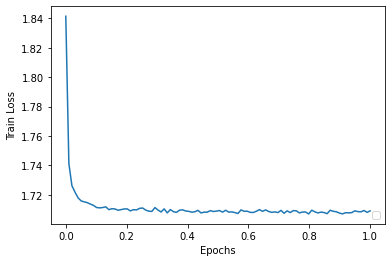

In [63]:
train_losses = results['train_losses']
x = np.linspace(0, 1, len(train_losses))
plt.plot(x, train_losses)
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
# plt.savefig('plots/cumulative_infection.png')
# plt.savefig('plots/cumulative_infection.eps', bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


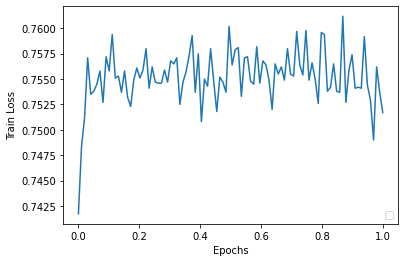

In [10]:
train_losses = results['val_accs']
x = np.linspace(0, 1, len(train_losses))
plt.plot(x, train_losses)
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('plots/cumulative_infection.png')
# plt.savefig('plots/cumulative_infection.eps', bbox_inches='tight')
plt.show()

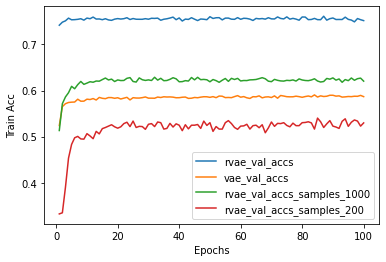

In [8]:
with open('saved_models/dict_rvae_rotated_mnist_classifier.pkl', 'rb') as handle:
    rvae_results = pickle.load(handle)
with open('saved_models/dict_vae_rotated_mnist_classifier.pkl', 'rb') as handle:
    vae_results = pickle.load(handle)
with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_1000.pkl', 'rb') as handle:
    rvae_results_samples_1000 = pickle.load(handle)
with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_200.pkl', 'rb') as handle:
    rvae_results_samples_200 = pickle.load(handle)
with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_1000.pkl', 'rb') as handle:
    vae_results_samples_1000 = pickle.load(handle)
with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_200.pkl', 'rb') as handle:
    vae_results_samples_200 = pickle.load(handle)
rvae_val_accs = rvae_results['val_accs']
rvae_val_accs_samples_1000 = rvae_results_samples_1000['val_accs']
rvae_val_accs_samples_200 = rvae_results_samples_200['val_accs']
vae_val_accs = vae_results['val_accs']
vae_val_accs_samples_1000 = vae_results_samples_1000['val_accs']
vae_val_accs_samples_200 = vae_results_samples_200['val_accs']
x = np.linspace(1, 100, 100)
plt.plot(x, rvae_val_accs, label = 'rvae_val_accs')
plt.plot(x, vae_val_accs, label = 'vae_val_accs')
plt.plot(x, rvae_val_accs_samples_1000, label = 'rvae_val_accs_samples_1000')
plt.plot(x, rvae_val_accs_samples_200, label = 'rvae_val_accs_samples_200')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Train Acc')
# plt.savefig('plots/cumulative_infection.png')
# plt.savefig('plots/cumulative_infection.eps', bbox_inches='tight')
plt.show()

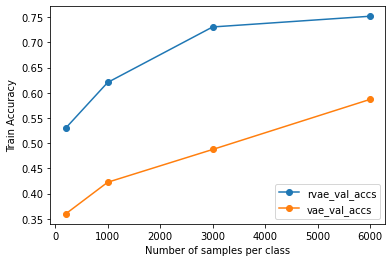

In [15]:
with open('saved_models/dict_rvae_rotated_mnist_classifier.pkl', 'rb') as handle:
    rvae_results = pickle.load(handle)
with open('saved_models/dict_vae_rotated_mnist_classifier.pkl', 'rb') as handle:
    vae_results = pickle.load(handle)
with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_1000.pkl', 'rb') as handle:
    rvae_results_samples_1000 = pickle.load(handle)
with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_3000.pkl', 'rb') as handle:
    rvae_results_samples_3000 = pickle.load(handle)
with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_200.pkl', 'rb') as handle:
    rvae_results_samples_200 = pickle.load(handle)
with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_1000.pkl', 'rb') as handle:
    vae_results_samples_1000 = pickle.load(handle)
with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_3000.pkl', 'rb') as handle:
    vae_results_samples_3000 = pickle.load(handle)
with open('saved_models/dict_vae_rotated_mnist_classifier_sampels_200.pkl', 'rb') as handle:
    vae_results_samples_200 = pickle.load(handle)
rvae_val_accs = rvae_results['val_accs'][-1]
rvae_val_accs_samples_1000 = rvae_results_samples_1000['val_accs'][-1]
rvae_val_accs_samples_200 = rvae_results_samples_200['val_accs'][-1]
rvae_val_accs_samples_3000 = rvae_results_samples_3000['val_accs'][-1]
vae_val_accs = vae_results['val_accs'][-1]
vae_val_accs_samples_1000 = vae_results_samples_1000['val_accs'][-1]
vae_val_accs_samples_3000 = vae_results_samples_3000['val_accs'][-1]
vae_val_accs_samples_200 = vae_results_samples_200['val_accs'][-1]

x = [200, 1000, 3000, 6000]
y1 = [rvae_val_accs_samples_200, rvae_val_accs_samples_1000, rvae_val_accs_samples_3000, rvae_val_accs]
y2 = [vae_val_accs_samples_200, vae_val_accs_samples_1000, vae_val_accs_samples_3000, vae_val_accs]
plt.plot(x, y1, label = 'rvae_val_accs', marker='o')
plt.plot(x, y2, label = 'vae_val_accs', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Number of samples per class')
plt.ylabel('Train Accuracy')
plt.savefig("sample_complexity.svg", bbox_inches='tight')
# plt.savefig('plots/cumulative_infection.png')
# plt.savefig('plots/cumulative_infection.eps', bbox_inches='tight')
plt.show()

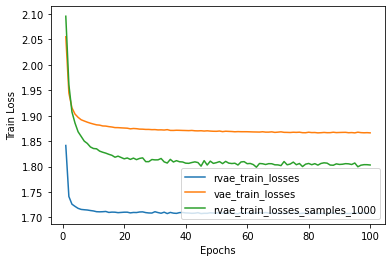

In [16]:
with open('saved_models/dict_rvae_rotated_mnist_classifier.pkl', 'rb') as handle:
    rvae_results = pickle.load(handle)
with open('saved_models/dict_vae_rotated_mnist_classifier.pkl', 'rb') as handle:
    vae_results = pickle.load(handle)
with open('saved_models/dict_rvae_rotated_mnist_classifier_sampels_1000.pkl', 'rb') as handle:
    rvae_results_samples_1000 = pickle.load(handle)
rvae_train_losses = rvae_results['train_losses']
vae_train_losses = vae_results['train_losses']
rvae_train_losses_samples_1000 = rvae_results_samples_1000['train_losses']
x = np.linspace(1, 100, 100)
plt.plot(x, rvae_train_losses, label = 'rvae_train_losses')
plt.plot(x, vae_train_losses, label = 'vae_train_losses')
plt.plot(x, rvae_train_losses_samples_1000, label = 'rvae_train_losses_samples_1000')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
# plt.savefig('plots/cumulative_infection.png')
# plt.savefig('plots/cumulative_infection.eps', bbox_inches='tight')
plt.show()

In [5]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
train_data, train_labels, train_angles = get_half_labels_rotated_mnist2(mnist_trainset, rotation_range=[-60, 61])
test_data, test_labels, test_angles = get_rotated_mnist(mnist_testset, rotation_range=[-60, 61])
train_loader = init_dataloader(train_data, batch_size=200)
test_loader = init_dataloader(test_data, batch_size=200)

In [6]:
torch.bincount(train_labels)

tensor([5923, 6742, 5958, 6131, 5842,   10,   10,   10,   10,   10])

In [10]:
%%capture cap_f1
in_dim = (28, 28)
# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
rvae = rVAE(in_dim, latent_dim=2, coord=1, seed=0)

# # Initialize SVI trainer
trainer = SVItrainer(rvae)

# Train for n epochs:ccc
for e in range(100):
    # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
    # It is optional, and the rvae will also work without it
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()
trainer.save_model(rvae, 'saved_models/rvae_half_labels_rtotaion2.pkl')
trainer.load_model(rvae, 'saved_models/rvae_half_labels_rtotaion2.pkl')

In [11]:
with open('saved_models/rvae_half_labels_rtotaion2.txt', 'w') as f: f.write(cap_f1.stdout)

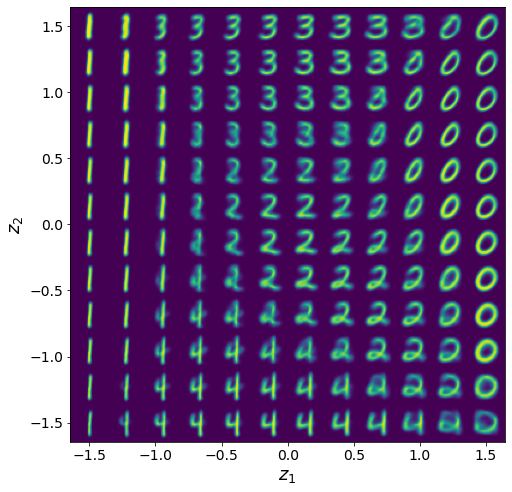

In [12]:
rvae.manifold2d(d=12, cmap="viridis")

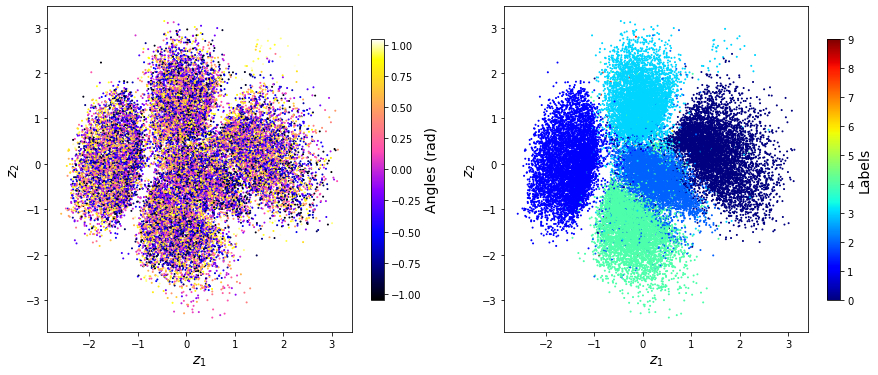

In [13]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In [14]:
z = rvae.encode(test_data)
x_decoded = rvae.decode(z)

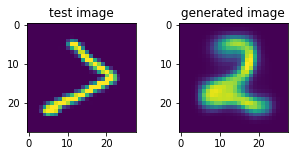

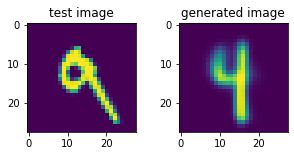

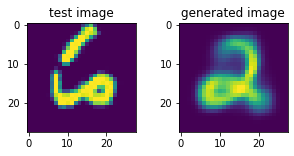

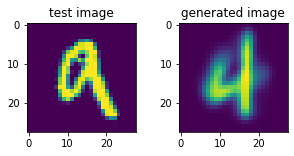

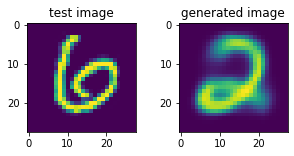

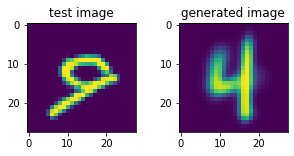

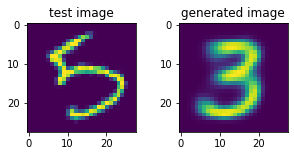

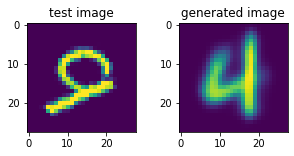

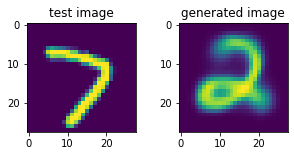

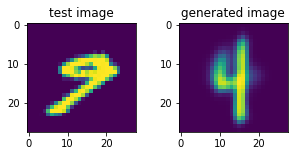

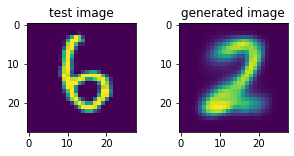

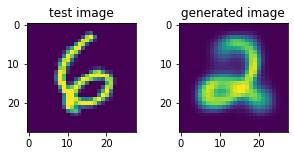

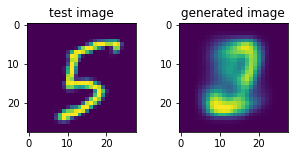

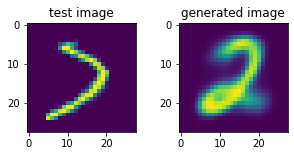

In [15]:
for i in range(30):
    if test_labels[i]>=5:
        # plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(5, 2))
        ax1.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
        ax1.set_title('test image')
        ax2.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())
        ax2.set_title('generated image')
        # plt.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
        # plt.figure()
        # plt.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())

#### Translated images

In [3]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_test = datasets.MNIST('data/mnist/', train=False, download=True)
train_data, train_labels, train_translations = get_translated_mnist(mnist_trainset, translation_range=[-7, 7])
test_data, test_labels, test_translations = get_translated_mnist(mnist_test, translation_range=[-7, 7])
train_loader = init_dataloader(train_data, batch_size=200)

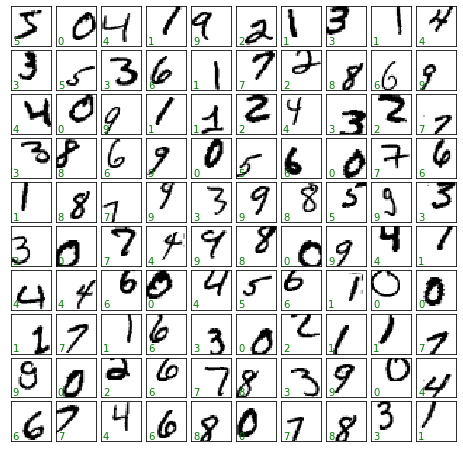

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

In [7]:
# %%capture cap_f1
in_dim = (28, 28)
# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
rvae = rVAE(in_dim, latent_dim=2, coord=2, seed=0)

# Initialize SVI trainer
trainer = SVItrainer(rvae)

# Train for n epochs:ccc
for e in range(200):
    # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
    # It is optional, and the rvae will also work without it
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()
# trainer.save_model(rvae, 'saved_models/rvae_translation.pkl')
# trainer.load_model(rvae, 'saved_models/rvae_translation.pkl')

tensor([[[-1.0000,  1.0000],
         [-1.0000,  0.9259],
         [-1.0000,  0.8519],
         ...,
         [ 1.0000, -0.8519],
         [ 1.0000, -0.9259],
         [ 1.0000, -1.0000]],

        [[-1.0000,  1.0000],
         [-1.0000,  0.9259],
         [-1.0000,  0.8519],
         ...,
         [ 1.0000, -0.8519],
         [ 1.0000, -0.9259],
         [ 1.0000, -1.0000]],

        [[-1.0000,  1.0000],
         [-1.0000,  0.9259],
         [-1.0000,  0.8519],
         ...,
         [ 1.0000, -0.8519],
         [ 1.0000, -0.9259],
         [ 1.0000, -1.0000]],

        ...,

        [[-1.0000,  1.0000],
         [-1.0000,  0.9259],
         [-1.0000,  0.8519],
         ...,
         [ 1.0000, -0.8519],
         [ 1.0000, -0.9259],
         [ 1.0000, -1.0000]],

        [[-1.0000,  1.0000],
         [-1.0000,  0.9259],
         [-1.0000,  0.8519],
         ...,
         [ 1.0000, -0.8519],
         [ 1.0000, -0.9259],
         [ 1.0000, -1.0000]],

        [[-1.0000,  1.0000],
       

KeyboardInterrupt: 

In [5]:
# with open('saved_models/rvae_translation_log.txt', 'w') as f: f.write(cap_f1.stdout)

In [5]:
z = rvae.encode(test_data)
x_decoded = rvae.decode(z)

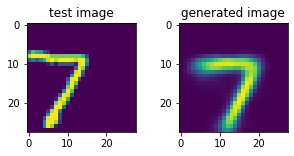

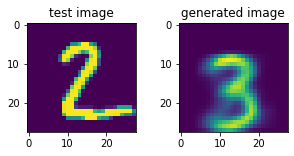

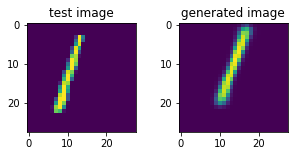

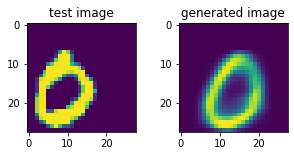

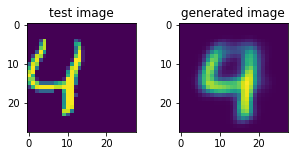

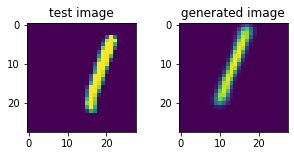

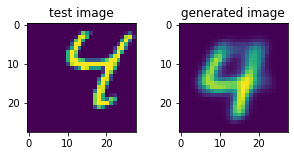

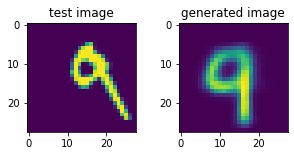

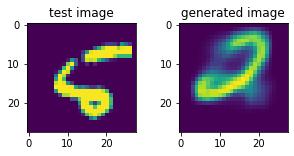

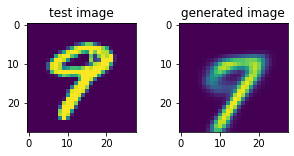

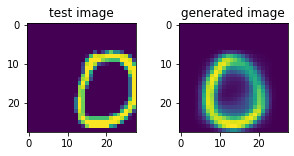

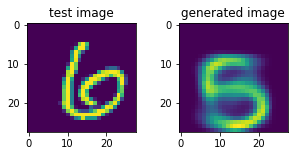

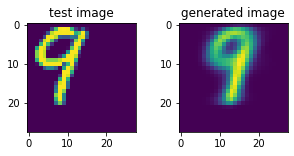

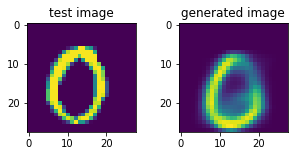

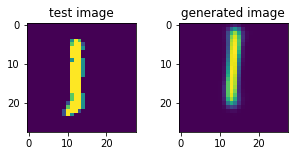

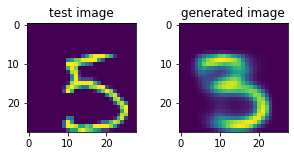

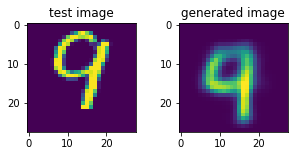

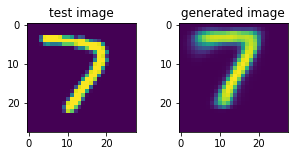

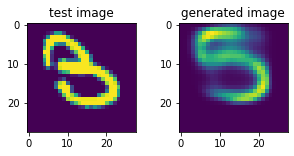

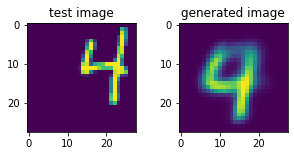

In [6]:
for i in range(20):
    # plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(5, 2))
    ax1.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
    ax1.set_title('test image')
    ax2.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())
    ax2.set_title('generated image')
    # plt.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
    # plt.figure()
    # plt.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())

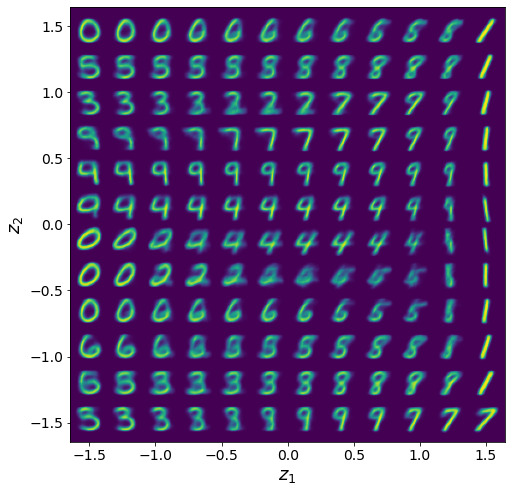

In [5]:
rvae.manifold2d(d=12, cmap="viridis")

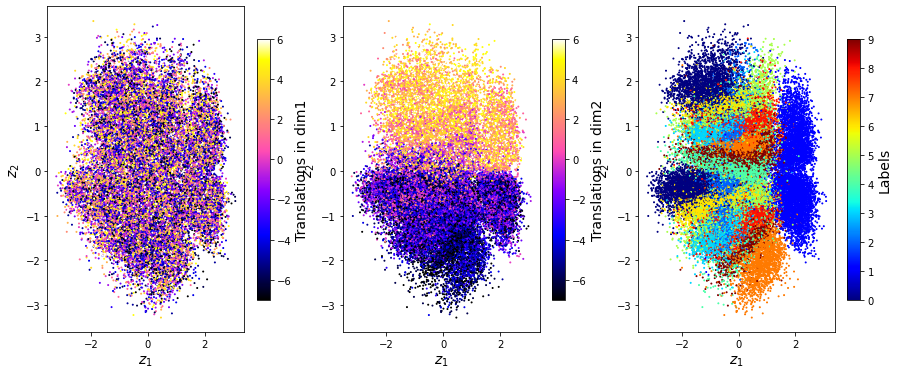

In [17]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(15, 6))

im1 = ax1.scatter(z_mean[:,3], z_mean[:,2], c=train_translations[:, 0], s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Translations in dim1", fontsize=14)
cbar1.ax.tick_params(labelsize=10)

im2 = ax2.scatter(z_mean[:,3], z_mean[:,2], c=train_translations[:, 1], s=1, cmap='gnuplot2')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Translations in dim2", fontsize=14)
cbar2.ax.tick_params(labelsize=10)


im3 = ax3.scatter(z_mean[:,3], z_mean[:,2], c=train_labels, s=1, cmap='jet')
ax3.set_xlabel("$z_1$", fontsize=14)
ax3.set_ylabel("$z_2$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("Labels", fontsize=14)
cbar3.ax.tick_params(labelsize=10);

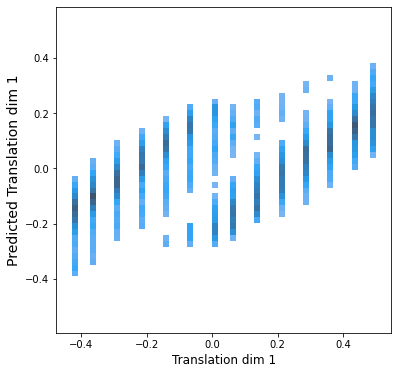

In [40]:
plt.figure(figsize=(6, 6))
plt.xlabel("Translation dim 1", fontsize=12)
plt.ylabel("Predicted Translation dim 1", fontsize=14)
ax = sns.histplot(x=-train_translations[:, 1]/14, y=0.1*z_mean[:, 0], bins=50, pthresh=.1);

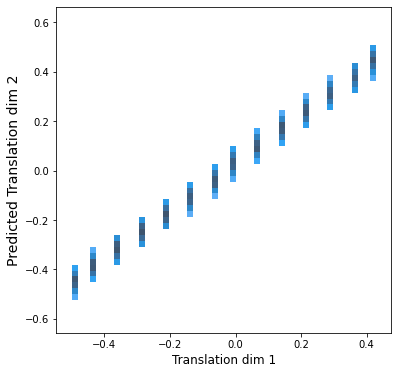

In [19]:
plt.figure(figsize=(6, 6))
plt.xlabel("Translation dim 1", fontsize=12)
plt.ylabel("Predicted Translation dim 2", fontsize=14)
ax = sns.histplot(x=train_translations[:, 0]/14, y=0.1*z_mean[:, 1], bins=50, pthresh=.1);

#### Translated and rotated data

In [4]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_test = datasets.MNIST('data/mnist/', train=False, download=True)
# train_data, train_labels, train_angles, train_translations = get_rotated_translated_mnist(mnist_trainset, rotation_range=[-60, 61], translation_range=[-7, 7])
# test_data, test_labels, test_angles, test_translations = get_rotated_translated_mnist(mnist_trainset, rotation_range=[-60, 61], translation_range=[-7, 7])
train_data, train_labels, train_angles = get_rotated_mnist(mnist_trainset, rotation_range=[-60, 61])
test_data, test_labels, test_angles = get_rotated_mnist(mnist_trainset, rotation_range=[-60, 61])
train_loader = init_dataloader(train_data, batch_size=200)

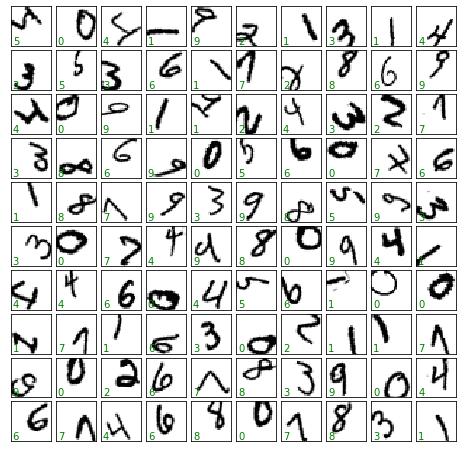

In [11]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

In [1]:
# %%capture cap_f1
in_dim = (28, 28)
# # Initialize probabilistic VAE model ->
# # (coord=0: vanilla VAE
# #  coord=1: rotations only
# #  coord=2: translations only
# #  coord=3: rotations+translations)
rvae = rVAE(in_dim, latent_dim=2, coord=3, seed=0)

# # Initialize SVI trainer
trainer = SVItrainer(rvae)

# Train for n epochs:ccc
for e in range(200):
    # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
    # It is optional, and the rvae will also work without it
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()
# trainer.save_model(rvae, 'saved_models/rvae_rotation_translation.pkl')
# trainer.load_model(rvae, 'saved_models/rvae_rotation_translation.pkl')
trainer.save_model(rvae, 'saved_models/rvae_rotation_translation_only_rotated_data.pkl')
trainer.load_model(rvae, 'saved_models/rvae_rotation_translation_only_rotated_data.pkl')


In [78]:
# with open('saved_models/rvae_rotation_translation.txt', 'w') as f: f.write(cap_f1.stdout)

In [7]:
# z = rvae.encode(test_data)
# x_decoded = rvae.decode(z)

In [ ]:
for i in range(50):
    # plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(5, 2))
    ax1.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
    ax1.set_title('test image')
    ax2.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())
    ax2.set_title('generated image')
    # plt.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
    # plt.figure()
    # plt.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())

In [ ]:
rvae.manifold2d(d=12, cmap="viridis")

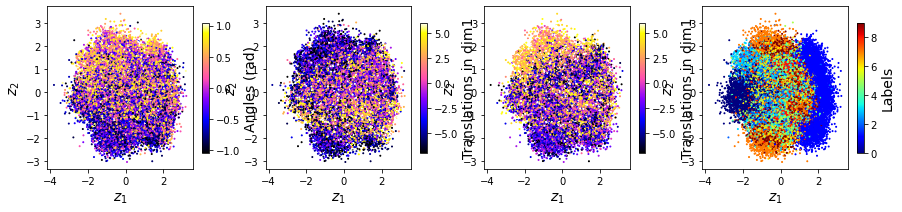

In [13]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize =(15, 3))

im1 = ax1.scatter(z_mean[:,4], z_mean[:,3], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)

im2 = ax2.scatter(z_mean[:,4], z_mean[:,3], c=train_translations[:, 0], s=1, cmap='gnuplot2')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Translations in dim1", fontsize=14)
cbar2.ax.tick_params(labelsize=10)

im3 = ax3.scatter(z_mean[:,4], z_mean[:,3], c=train_translations[:, 1], s=1, cmap='gnuplot2')
ax3.set_xlabel("$z_1$", fontsize=14)
ax3.set_ylabel("$z_2$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("Translations in dim1", fontsize=14)
cbar3.ax.tick_params(labelsize=10)

im4 = ax4.scatter(z_mean[:,4], z_mean[:,3], c=train_labels, s=1, cmap='jet')
ax4.set_xlabel("$z_1$", fontsize=14)
ax4.set_ylabel("$z_2$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("Labels", fontsize=14)
cbar4.ax.tick_params(labelsize=10);

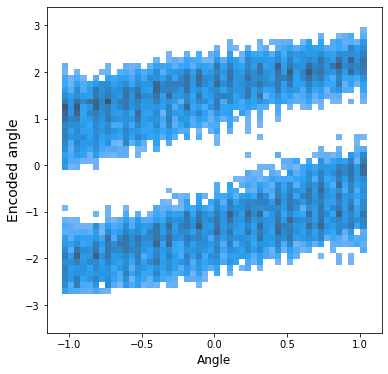

In [14]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=train_angles, y=z_mean[:, 0], bins=50, pthresh=.1);

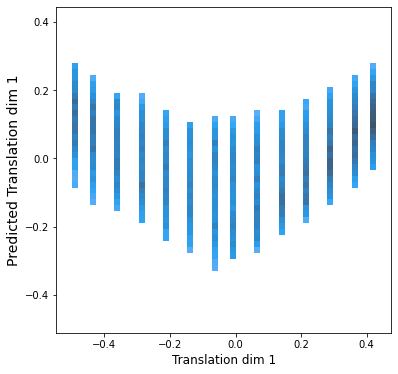

In [23]:
plt.figure(figsize=(6, 6))
plt.xlabel("Translation dim 1", fontsize=12)
plt.ylabel("Predicted Translation dim 1", fontsize=14)
ax = sns.histplot(x=train_translations[:, 0]/14, y=0.1*z_mean[:, 2], bins=50, pthresh=.1);

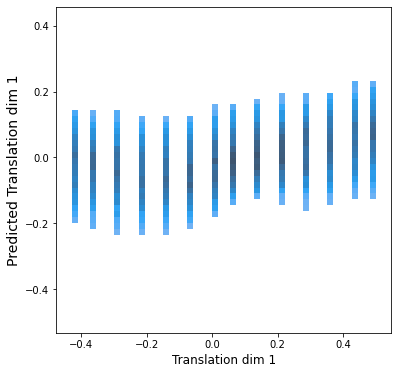

In [22]:
plt.figure(figsize=(6, 6))
plt.xlabel("Translation dim 1", fontsize=12)
plt.ylabel("Predicted Translation dim 1", fontsize=14)
ax = sns.histplot(x=-train_translations[:, 1]/14, y=0.1*z_mean[:, 1], bins=50, pthresh=.1);

In [10]:
TrainResult = {'train_losses': [], 'val_accs': []}
TrainResult['train_losses'] = [1, 2]